In [2]:
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import os

print("TensorFlow:", tf.__version__)
print("MediaPipe:", mp.__version__)


TensorFlow: 2.19.0
MediaPipe: 0.10.14


In [3]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.7
)


In [4]:
def extract_keypoints(results):
    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]
        return np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]).flatten()
    else:
        return np.zeros(21 * 3)

def collect_data(video_source=0, num_samples=100, label="hello"):
    X, y = [], []
    cap = cv2.VideoCapture(video_source)
    count = 0
    print(f"Collecting data for label '{label}'... Press 'q' to quit early.")
    while cap.isOpened() and count < num_samples:
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)
        keypoints = extract_keypoints(results)
        X.append(keypoints)
        y.append(label)
        if results.multi_hand_landmarks:
            for landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(frame, landmarks, mp_hands.HAND_CONNECTIONS)
        cv2.putText(frame, f"{label} {count}/{num_samples}", (10,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        cv2.imshow('Collecting Data', frame)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        count += 1
    cap.release()
    cv2.destroyAllWindows()
    return np.array(X), np.array(y)


In [6]:
import cv2

cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
print("camera opened?", cap.isOpened())
cap.release()


camera opened? True


In [7]:
# STEP 4 — COLLECT DATA FOR 7 NATURAL WORDS

# collect 150 samples per word (keep hand inside box, do not move)

X_hello,  y_hello  = collect_data("hello",  num_samples=150)
X_yes,    y_yes    = collect_data("yes",    num_samples=150)
X_no,     y_no     = collect_data("no",     num_samples=150)
X_thanks, y_thanks = collect_data("thanks", num_samples=150)
X_please, y_please = collect_data("please", num_samples=150)
X_good,   y_good   = collect_data("good",   num_samples=150)
X_sorry,  y_sorry  = collect_data("sorry",  num_samples=150)

print("DATA COLLECTION COMPLETED")


c:\Users\anand\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


DATA COLLECTION COMPLETED


In [8]:
X = np.concatenate([X_hello, X_yes, X_no, X_thanks, X_please, X_good, X_sorry])
y = np.concatenate([y_hello, y_yes, y_no, y_thanks, y_please, y_good, y_sorry])

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1050, 63)
y shape: (1050,)


In [9]:
# STEP 5 — Encode labels and split dataset

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# encode text labels → integers
lb = LabelEncoder()
y_encoded = lb.fit_transform(y)

# convert to one-hot
y_categorical = to_categorical(y_encoded)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

print("Classes:", lb.classes_)
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Classes: ['good' 'hello' 'no' 'please' 'sorry' 'thanks' 'yes']
Training samples: 840
Testing samples: 210


In [10]:
# STEP 6 — Build and Train a stronger neural network

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

input_dim = X_train.shape[1]   # should be 63

model = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=16
)

print("Training finished")


c:\Users\anand\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3393 - loss: 1.7648 - val_accuracy: 0.5238 - val_loss: 1.4463
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6000 - loss: 1.2135 - val_accuracy: 0.8381 - val_loss: 0.7791
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7464 - loss: 0.7520 - val_accuracy: 0.8905 - val_loss: 0.4430
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8679 - loss: 0.4570 - val_accuracy: 0.9571 - val_loss: 0.2275
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9024 - loss: 0.3060 - val_accuracy: 0.9857 - val_loss: 0.1558
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9250 - loss: 0.2627 - val_accuracy: 0.9810 - val_loss: 0.1314
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9190 - loss: 0.2391 - val_accuracy: 0.9571 - val_loss: 0.1336
Epoch 8/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9512 - loss: 0.1772 - val_accuracy: 0.9952 - val_loss

In [18]:
# STEP 7 — Save model and encoder for backend

model.save("sign_language_model.h5")
joblib.dump(lb, "label_encoder.pkl")

print("Model saved as 'sign_language_model.h5'")
print("Label encoder saved as 'label_encoder.pkl'")


Model saved as 'sign_language_model.h5'
Label encoder saved as 'label_encoder.pkl'


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9952 - loss: 0.0092 

TEST ACCURACY: 0.9952


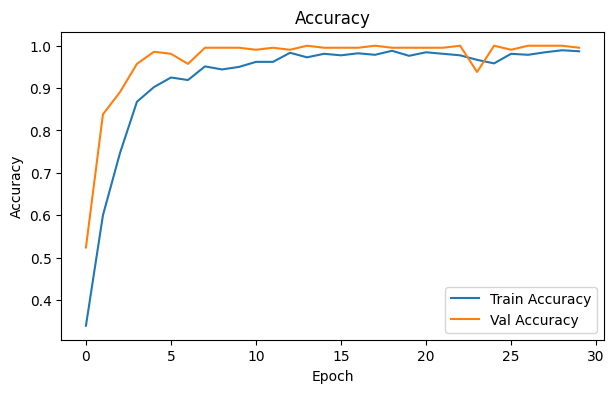

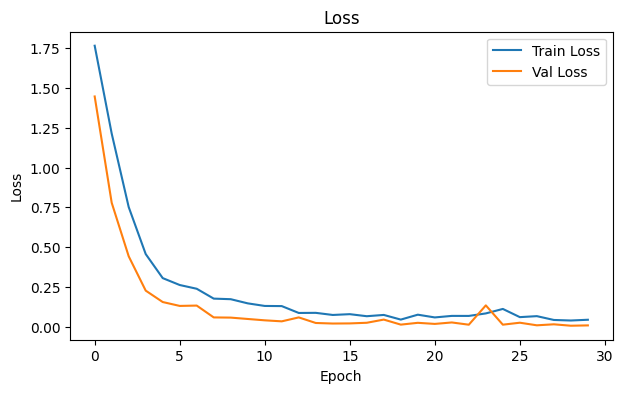


Evaluation Completed.


In [11]:
# STEP 8 — Evaluate and plot graphs

import matplotlib.pyplot as plt

# evaluate test accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTEST ACCURACY: {test_acc:.4f}")

# accuracy graph
plt.figure(figsize=(7,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# loss graph
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

print("\nEvaluation Completed.")
